In [61]:
import requests
from dataclasses import dataclass
from typing import List, Any, Dict
import pandas as pd

In [46]:
# Define the Prometheus query and time range
query = "SYSACT__AVERAGE_CPU_RATE"
setp = '15d' # 3 hours

# Define the Prometheus server URL
url = "http://localhost:9090/api/v1/query"

# Define the request parameters
params = {
    "query": f'{query}[{setp}]'
}

response = requests.get(url, params=params)
data = response.json()["data"]["result"]
for d in data:
    print(d)

{'metric': {'__name__': 'SYSACT__AVERAGE_CPU_RATE', 'driver_class': 'com.ibm.as400.access.AS400JDBCDriver', 'hostname': 'ut33p23', 'instance': '9.5.249.229:9853', 'job': 'prometheus'}, 'values': [[1680805207.846, '100'], [1680805267.802, '100'], [1680805327.76, '100'], [1680805387.713, '100'], [1680805447.669, '100'], [1680805507.625, '100'], [1680805567.581, '100'], [1680805627.537, '100'], [1680805687.492, '100'], [1680805747.447, '75'], [1680805807.403, '100'], [1680805867.359, '100'], [1680805927.315, '133.33'], [1680805987.27, '100'], [1680806047.225, '100'], [1680806107.181, '100'], [1680806167.137, '100'], [1680806227.092, '100'], [1680806287.048, '91.66'], [1680806347.004, '87.5'], [1680806406.961, '100'], [1680806466.915, '100'], [1680806526.87, '100'], [1680806586.826, '100'], [1680806646.782, '102.04'], [1680806706.775, '100'], [1680806766.736, '100'], [1680806826.693, '150'], [1680806886.65, '100'], [1680806946.604, '100'], [1680807006.561, '100'], [1680807066.518, '66.66']

In [72]:

class PrometheusQuery:
    def __init__(self, url: str = "http://localhost:9090/api/v1/query") -> None:
        self.url = url
        self.metrics: Dict[str, "PrometheusMetric"] = {}

    def _get_data(self, query: str, step: str) -> List[dict]:
        params = {
            "query": f'{query}[{step}]'
        }
        response = requests.get(self.url, params=params)
        return response.json()["data"]["result"]
    
    def create_metrics(self, query: str, step: str) -> List["PrometheusMetric"]:
        return [PrometheusMetric(metric) for metric in self._get_data(query, step)]
    
    def dataframe(self, query, step) -> pd.DataFrame:
        self.metrics_ = self.create_metrics(query, step)
        
        # add metrics to client
        self.metrics[query] = self.metrics_
        
        values = {}
        for result in self.metrics_:
            host = result.hostname
            values[host] = [[pd.Timestamp(k[0], unit='s'), float(k[1])] for k in result.values]
            
        # Calculate the minimum and maximum number of rows across all hosts
        min_rows = min(len(v) for v in values.values())
        max_rows = max(len(v) for v in values.values())

        # Drop the last rows for each host if necessary to make them all the same length
        if min_rows < max_rows:
            num_rows = min_rows
            for host, v in values.items():
                if len(v) > num_rows:
                    values[host] = v[:num_rows]
                    
        # Create a list of dataframes from the dictionary
        dfs = [pd.DataFrame(values[key], columns=['time', f"{key}_{query}"]).set_index('time') for key in values]

        # Concatenate the dataframes horizontally
        df = pd.concat(dfs, axis=1)
        
        return df
    
    def run_query(self, query: str, step: str = "1h") -> pd.DataFrame:
        return self.dataframe(query, step)
        
           
    def get_metrcs(self) -> List["PrometheusMetric"]:
        return self.metrics
        
            
    
    
    
class PrometheusMetric:
    def __init__(self, metric: dict) -> None:
        self.metric = metric
        self.name = metric["metric"]["__name__"]
        self.driver_class = metric["metric"]["driver_class"]
        self.hostname = metric["metric"]["hostname"]
        self.instance = metric["metric"]["instance"]
        self.job = metric["metric"]["job"]
        self.values = metric["values"]
    
    def __repr__(self) -> str:
        return f"{self.metric}"
        
    


In [73]:
avg_cpu_rate = "SYSACT__AVERAGE_CPU_RATE"
avg_cpu_util = "SYSACT__AVERAGE_CPU_UTILIZATION"
remote_connections = "REMOTE_CONNECTIONS"

step = '15d'

client = PrometheusQuery(url)
avg_cpu_rate_df = client.run_query(avg_cpu_rate, step)
avg_cpu_util_df = client.run_query(avg_cpu_util, step)
remote_connections_df = client.run_query(remote_connections, step)
client.metrics



{'SYSACT__AVERAGE_CPU_RATE': [{'metric': {'__name__': 'SYSACT__AVERAGE_CPU_RATE', 'driver_class': 'com.ibm.as400.access.AS400JDBCDriver', 'hostname': 'ut33p23', 'instance': '9.5.249.229:9853', 'job': 'prometheus'}, 'values': [[1680805207.846, '100'], [1680805267.802, '100'], [1680805327.76, '100'], [1680805387.713, '100'], [1680805447.669, '100'], [1680805507.625, '100'], [1680805567.581, '100'], [1680805627.537, '100'], [1680805687.492, '100'], [1680805747.447, '75'], [1680805807.403, '100'], [1680805867.359, '100'], [1680805927.315, '133.33'], [1680805987.27, '100'], [1680806047.225, '100'], [1680806107.181, '100'], [1680806167.137, '100'], [1680806227.092, '100'], [1680806287.048, '91.66'], [1680806347.004, '87.5'], [1680806406.961, '100'], [1680806466.915, '100'], [1680806526.87, '100'], [1680806586.826, '100'], [1680806646.782, '102.04'], [1680806706.775, '100'], [1680806766.736, '100'], [1680806826.693, '150'], [1680806886.65, '100'], [1680806946.604, '100'], [1680807006.561, '10

<Axes: xlabel='time'>

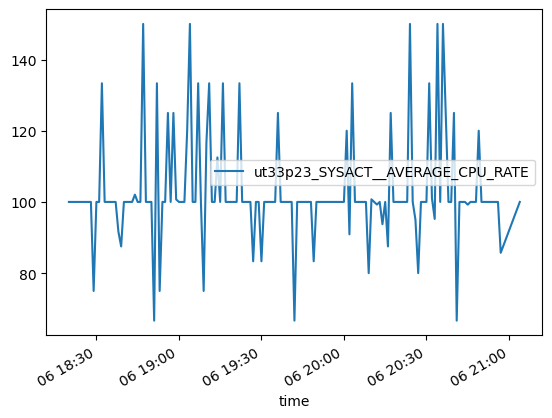

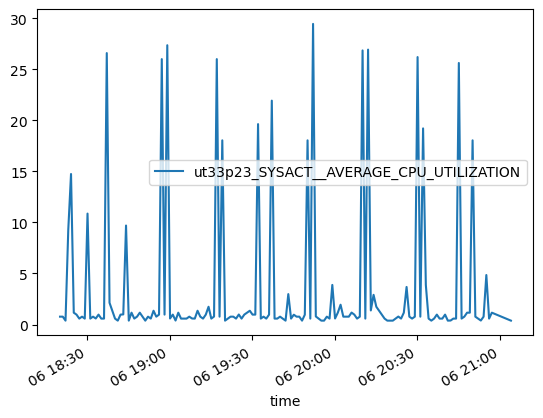

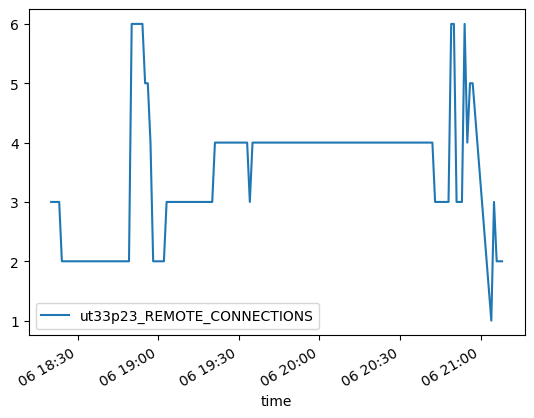

In [77]:
# pd.concat([avg_cpu_rate_df, avg_cpu_util_df], axis=1)
avg_cpu_rate_df.plot()
avg_cpu_util_df.plot()
remote_connections_df.plot()